In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

device = "cuda"
#device = "cpu"
load_weight = False
save_dir        = "./"
weight_float32  = "mnist_model_truncation.pt"
data_scaling    = 64


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
trainset = datasets.MNIST('./trainset', download=True, train=True, transform=transform)
#trainset = datasets.MNIST('./trainset', download=True, train=True)

valset = datasets.MNIST('./testset', download=True, train=False, transform=transform)
#valset = datasets.MNIST('./testset', download=True, train=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
print(trainset)
dataiter = iter(trainloader)
images, labels = dataiter.next()
#images = transforms.functional.convert_image_dtype(images, torch.int8)
#print(type(dataiter))
#for p in dataiter:
#    print(p)

print(images.shape)
print(labels.shape)
#print(images[0].numpy())


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./trainset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
torch.Size([64, 1, 28, 28])
torch.Size([64])


array([[[-64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ],
        [-64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ],
        [-64.       , -64.       , -64.       , -64.       ,
         -64.       , -64.       , -64.       , -64.       ,
         -64.       , 

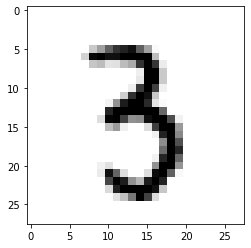

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
images[0].numpy()*data_scaling

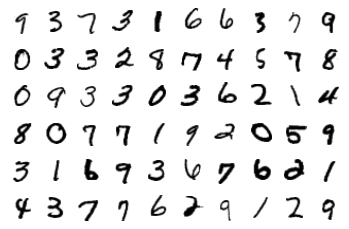

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow((images[index].numpy()*data_scaling).squeeze(), cmap='gray_r')

In [ ]:
import os
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
"""
model = nn.Sequential(torch.quantization.QuantStub(),
                      nn.Linear(input_size, hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], output_size),
                      torch.quantization.DeQuantStub(),
                      nn.LogSoftmax(dim=1))
"""

class M(torch.nn.Module):
    def __init__(self):
        super(M, self).__init__()
        self.FC1 = torch.nn.Linear(input_size, output_size)
        #self.FC1     = torch.nn.Linear(input_size, hidden_sizes[0])
        #self.FC2     = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        #self.FC3     = torch.nn.Linear(hidden_sizes[1], output_size)
        self.lgs     = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.FC1(x)
        #x = self.FC2(x)
        #x = self.FC3(x)
        return self.lgs(x)

model = M()
model.train()
#model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
#model.qconfig = torch.quantization.qconfig.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8), weight=torch.quantization.default_observer.with_args(dtype=torch.qint8))
#model = torch.quantization.prepare_qat(model)
model.to(device)


M(
  (FC1): Linear(in_features=784, out_features=10, bias=True)
  (lgs): LogSoftmax(dim=1)
)

In [ ]:
criterion = nn.NLLLoss().to(device)
images, labels = next(iter(trainloader))
images = (images.view(images.shape[0], -1)*data_scaling).to(device)
labels = labels.to(device)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
#print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
#print('After backward pass: \n', model[0].weight.grad)

In [ ]:
if not load_weight:
    #optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    time0 = time()
    epochs = 100
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = (images.view(images.shape[0], -1)*data_scaling).to(device)
            labels = labels.to(device)
            
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            loss = running_loss/len(trainloader)
            print(f"Epoch {e} - Training loss: {loss}")
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    torch.save(model.state_dict(), os.path.join(weight_float32))
else:
    model.load_state_dict(torch.load(os.path.join(save_dir, weight_float32)))

Epoch 0 - Training loss: 2.8112705073980635
Epoch 1 - Training loss: 1.46879979237509
Epoch 2 - Training loss: 1.2867138834197576
Epoch 3 - Training loss: 1.290275032757156
Epoch 4 - Training loss: 1.1929423139849578
Epoch 5 - Training loss: 1.1604298303739777
Epoch 6 - Training loss: 1.1267399284472344
Epoch 7 - Training loss: 1.090870772487081
Epoch 8 - Training loss: 1.078182801169389
Epoch 9 - Training loss: 1.0635092067413097
Epoch 10 - Training loss: 1.0484300810805978
Epoch 11 - Training loss: 1.0602379311948442
Epoch 12 - Training loss: 1.0166281409390858
Epoch 13 - Training loss: 1.08324538321415
Epoch 14 - Training loss: 1.000857809824603
Epoch 15 - Training loss: 1.0188503979540455


KeyboardInterrupt: ignored

Predicted Digit = 3
<class 'torch.Tensor'>


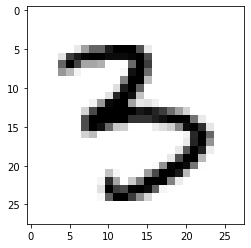

In [ ]:
images, labels = next(iter(valloader))
images = images*data_scaling

img = images[0].view(1, 784).to(device)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.to("cpu").numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
print(type(img.view(1, 28, 28)))
plt.imshow(img.view(1, 28, 28).to("cpu").numpy().squeeze(), cmap='gray_r');

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    images = images*data_scaling
    for i in range(len(labels)):
        img = images[i].view(1, 784).to(device)
        with torch.no_grad():
            logps = model(img)
            ps = torch.exp(logps)
            probab = list(ps.to("cpu").numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if (true_label == pred_label):
                correct_count += 1
            all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.8568


#Scaling

In [ ]:
def mymin(a, b):
    if (a<b):
        return a
    else:
        return b

def mymax(a, b):
    if (a<b):
        return b
    else:
        return a

def scale(w_arr, b_arr, s_min, s_max):
    arr_min = mymin(w_arr.min(), b_arr.min())
    arr_max = mymax(w_arr.max(), b_arr.max())
    arr_range = arr_max-arr_min
    s_range = s_max-s_min
    return ((w_arr-arr_min)*s_range/arr_range+s_min).astype(int), ((b_arr-arr_min)*s_range/arr_range+s_min).astype(int)

scaling_min = -100
scaling_max = 100
scaling_range = scaling_max-scaling_min

model.to("cpu")
model.eval()

FC1_w = model.FC1.weight
FC1_w.requires_grad=False
FC1_w = FC1_w.numpy()
FC1_b = model.FC1.bias
FC1_b.requires_grad=False
FC1_b = FC1_b.numpy()

w_min   = FC1_w.min()
w_max   = FC1_w.max()
b_min   = FC1_b.min()
b_max   = FC1_b.max()
w_range = w_max-w_min
b_range = b_max-b_min
print(f"Weight min:{w_min}, max:{w_max}, range{w_range}")
print(f"Bias min:{b_min}, max:{b_max}, range{b_range}")

FC1_w_scaled, FC1_b_scaled = scale(FC1_w, FC1_b, scaling_min, scaling_max)

print(f"Scaled Weight:{FC1_w_scaled}")
print(f"Scaled Bias:{FC1_b_scaled}")


Weight min:-0.06804159283638, max:0.07792917639017105, range0.14597076177597046
Bias min:-0.027455303817987442, max:0.025375908240675926, range0.05283121019601822
Scaled Weight:[[ 36  -5  33 ...  31 -38 -49]
 [ -8  42   1 ...  32  23  10]
 [ 30   0 -12 ...  -7 -39 -17]
 ...
 [-10 -42  25 ... -31 -26 -48]
 [-60  23  27 ...  14 -36  10]
 [-11  30 -46 ... -43  10 -15]]
Scaled Bias:[-44   6 -14 -22  10  21  27   4  -8  23]


In [ ]:
correct_count, all_count = 0, 0
lgs = torch.nn.LogSoftmax(dim=1)
x_min = float('inf')
x_max = -float('inf')

for images, labels in valloader:
    images = images.numpy()*data_scaling
    labels = labels.numpy()
    for i in range(len(labels)):
        img = images[i].reshape(1, 784)
        #logps = model(img)
        x = (np.matmul(img, FC1_w_scaled.transpose())+FC1_b_scaled)
        #x = (np.matmul(img, FC1_w.transpose())+FC1_b)
        if (x_min > x.min()):
            x_min = x.min()
        if (x_max < x.max()):
            x_max = x.max()
        x = x / scaling_range
        logps = lgs(torch.tensor(x))
        ps = torch.exp(logps)
        probab = list(ps.to("cpu").numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels[i]
        if (true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))
print(f"MatMul Result range = min:{x_min}, max:{x_max}")

Number Of Images Tested = 10000

Model Accuracy = 0.8526
MatMul Result range = min:-105757.13859939575, max:398478.86309432983
